In [1]:
import os
import h5py
import pandas as pd
from lbn import LBN, LBNLayer
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import datasets, layers, models
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [15]:
h5f_X_train = h5py.File('X_train.h5', 'r')
X_train = h5f_X_train['data'][:]
h5f_X_train.close()

h5f_y_train = h5py.File('y_train.h5', 'r')
y_train = h5f_y_train['data'][:]
h5f_y_train.close()



h5f_X_test = h5py.File('X_test.h5', 'r')
X_test = h5f_X_test['data'][:]
h5f_X_test.close()

h5f_y_test = h5py.File('y_test.h5', 'r')
y_test = h5f_y_test['data'][:]
h5f_y_test.close()


"""
h5f_X_val = h5py.File('X_val.h5', 'r')
X_val = h5f_X_val['data'][:]
h5f_X_val.close()

h5f_y_val = h5py.File('y_val.h5', 'r')
y_val = h5f_y_val['data'][:]
h5f_y_val.close()
"""

"\nh5f_X_val = h5py.File('X_val.h5', 'r')\nX_val = h5f_X_val['data'][:]\nh5f_X_val.close()\n\nh5f_y_val = h5py.File('y_val.h5', 'r')\ny_val = h5f_y_val['data'][:]\nh5f_y_val.close()\n"

In [3]:
input_shape = (13,4)

inputs = keras.Input(shape=input_shape)

x = LBNLayer(input_shape, 13, boost_mode=LBN.PAIRS, features=["E", "pt", "eta", "phi", "m", "pair_cos"])(inputs)

x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc1_relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc2_relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc3_relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc4_relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc5_relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc6_relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc7_relu')(x)
x = BatchNormalization()(x)
x = Dense(1024, kernel_initializer='lecun_uniform', activation='relu', name='fc8_relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid', name='output_sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="lbn-2epochs")

In [4]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()
tf.keras.utils.plot_model(model, "lbn-2epochs.png", show_shapes=True)

Model: "lbn-2epochs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 4)]           0         
_________________________________________________________________
LBN (LBNLayer)               (None, 143)               338       
_________________________________________________________________
fc1_relu (Dense)             (None, 1024)              147456    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
fc2_relu (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
fc3_relu (Dense)             (None, 1024)              

In [6]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 2, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/2
14192/14192 [==============================] - 226s 16ms/step - loss: 0.2817 - accuracy: 0.8855 - val_loss: 0.2551 - val_accuracy: 0.8969
Epoch 2/2
14192/14192 [==============================] - 226s 16ms/step - loss: 0.2553 - accuracy: 0.8957 - val_loss: 0.2464 - val_accuracy: 0.8997


In [8]:
model.save('lbn-2epochs')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: lbn-2epochs\assets


In [ ]:
# loaded_model = keras.models.load_model('lbn-2epochs')

In [9]:
import matplotlib.pyplot as plt

In [10]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

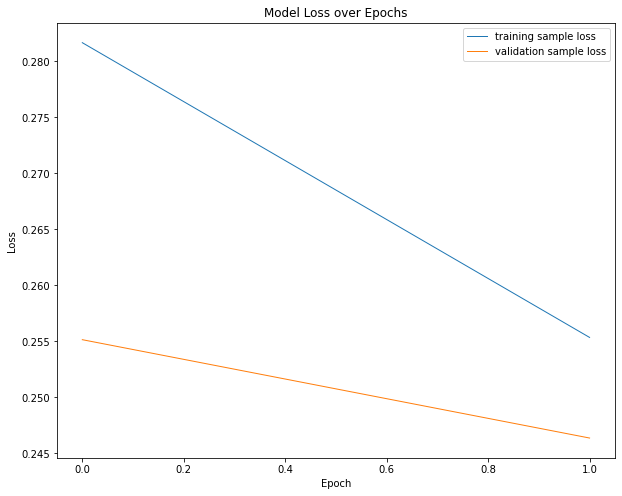

In [11]:
learningCurve(history)

In [12]:
labels_pred = model.predict(features_val)

NameError: name 'features_val' is not defined

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [16]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='lbn-2epochs')

NameError: name 'labels' is not defined